In [835]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [836]:
# Load the dataset
bike_sharing_df = pd.read_csv('day.csv')

In [837]:
# have a peek at the dataset
bike_sharing_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [838]:
# get the dataset info
bike_sharing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### The dataset doesn't have any null values which is nice

In [839]:
# describe the numeric values
bike_sharing_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### Observations  
  
-> At a quick glance the variables like temp, atemp, windspeed, casual, registered and cnt look good.  
  
-> hum seem to have a 0 somewhere (min value shows as 0), however looking at the dataset, there is only one value that is 0 which is improbable.    
   Will try to fix it during data cleaning and pre processing.  
     
-> Will deal with other variables during data cleaning and pre processing. 

### 'instant" is basically like a serial number, it doesn't have any predictive power, so dropped it. Also drop casual and registered as they together basically the count, since we have count we do not need it.

In [840]:
# drop variable instant, casual and registered
bike_sharing_df = bike_sharing_df.drop(['instant', 'casual', 'registered'], axis=1)

In [841]:
# humidity has just one zero value. Will try to see how best to replace that value.
print("Mode: ", bike_sharing_df['hum'].mode())
print("Median: ", bike_sharing_df['hum'].median())
print("Mean: ", bike_sharing_df['hum'].mean())

# Since this is time series data and humidity is something that can be similar in consecutive / adjacent days print those values as well.
ref_index = bike_sharing_df[bike_sharing_df['hum'] == 0].index[0]
hum_prev_day = bike_sharing_df.loc[ref_index - 1, 'hum'] if ref_index > 0 else None
hum_next_day = bike_sharing_df.loc[ref_index + 1, 'hum'] if ref_index > 0 else None

print("humidity on previous day: ", hum_prev_day)
print("humidity on next day: ", hum_next_day)
print("average humidity of the adjacent days: ", (hum_prev_day + hum_next_day)/2)

Mode:  0    61.3333
dtype: float64
Median:  62.625
Mean:  62.76517493150685
humidity on previous day:  77.5417
humidity on next day:  64.9565
average humidity of the adjacent days:  71.2491


### Humidity Anomaly - Replacement Reasoning
Median, Mean, and Mode hover around 62 percent.  
Considering the time series nature of humidity, adjacent records were examined, and they were also close in value.
There are three options:  
  
1) Substitute with Central Tendency: Since Mean, Median, and Mode are close, replacing zero with any of these aligns with the overall data distribution.  
  
2) Use Average of Adjacent Days: Given the significance of time series data, averaging humidity values from adjacent days is a crucial factor.  
  
3) Consider Dropping the Record: Other columns in the row show normal values, making dropping the row a plausible option as this will not impact the analysis.  
    
Considering these points, imputing with the average of adjacent days proves to be the best option:  
  
Dropping the record sacrifices a data point for that day of the year.  
Imputing with Mean/Median/Mode maintains overall distribution but lacks context sensitivity.  
Imputing with adjacent values preserves context sensitivity, aligns with time series trends, and enhances predictive model relevance.

In [842]:
# impute the average of the adjacent values
bike_sharing_df.loc[ref_index, 'hum'] =  (hum_prev_day + hum_next_day)/2

In [843]:
# describe humidity again and confirm that it looks ok
bike_sharing_df['hum'].describe()

count    730.000000
mean      62.862776
std       14.049705
min       18.791700
25%       52.052075
50%       62.708350
75%       72.989575
max       97.250000
Name: hum, dtype: float64

In [844]:
# removing temp as temp and a_temp will have the same impact
bike_sharing_df = bike_sharing_df.drop('temp', axis=1)

In [845]:
# convert season, weathersit, weekday to corresponding strings
bike_sharing_df['season'] = bike_sharing_df['season'].replace({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

In [846]:
# Note: There is an anomaly in the dataset - Jan 1st 2018 is a Monday whereas here in the dataset as per the data, it has considered it as a Saturday and the value of working day etc suggests this way.
# So Considering the dataset, substituting the values as that makes sense as per dataset.
bike_sharing_df['weekday'] = bike_sharing_df['weekday'].replace({0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 
                                                                 4:'Thursday', 5:'Friday', 6:'Saturday'}) 

In [847]:
bike_sharing_df['weathersit'] = bike_sharing_df['weathersit'].replace({1: 'Clear / Partly cloudy',
                                                                     2: 'Misty / Cloudy',
                                                                     3: 'Light Snow, Light Rain and Thunderstorm / Scattered clouds',
                                                                     4: 'Heavy Rain / Ice Pallets / Thunderstorm / Mist, Snow / Fog'}) 


In [848]:
# map mnth to corresponding month
bike_sharing_df['mnth'] = bike_sharing_df['mnth'].replace({1: 'Jan',
                                                           2: 'Feb',
                                                           3: 'Mar',
                                                           4: 'Apr',
                                                           5: 'May',
                                                           6: 'Jun',
                                                           7: 'Jul',
                                                           8: 'Aug',
                                                           9: 'Sep',
                                                          10: 'Oct',
                                                          11: 'Nov',
                                                          12: 'Dec'}) 


### Now the data is cleaned, Let's do a pairplot with numerical values

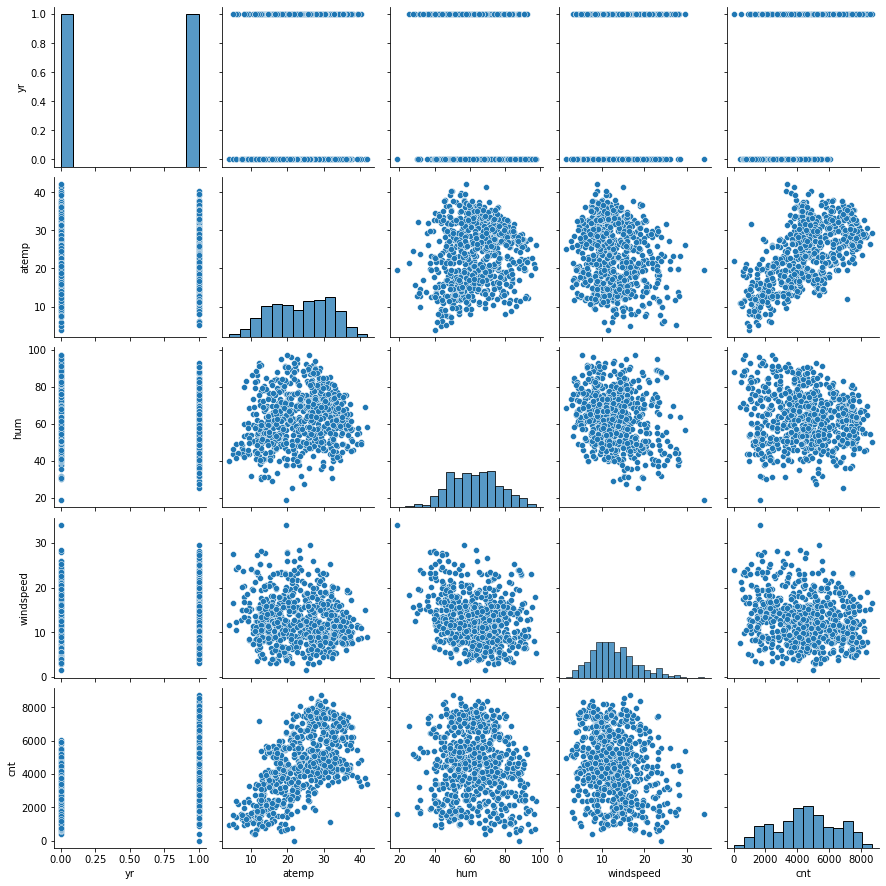

In [849]:
num_vals = ['yr','atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(bike_sharing_df[num_vals])
plt.show()

### Pair plot observations  
1) There is a linear relationship with year and count. In the year 2019 there has been a significant increase in the count / total usage.    

2) There is a linear relationship between atemp and count

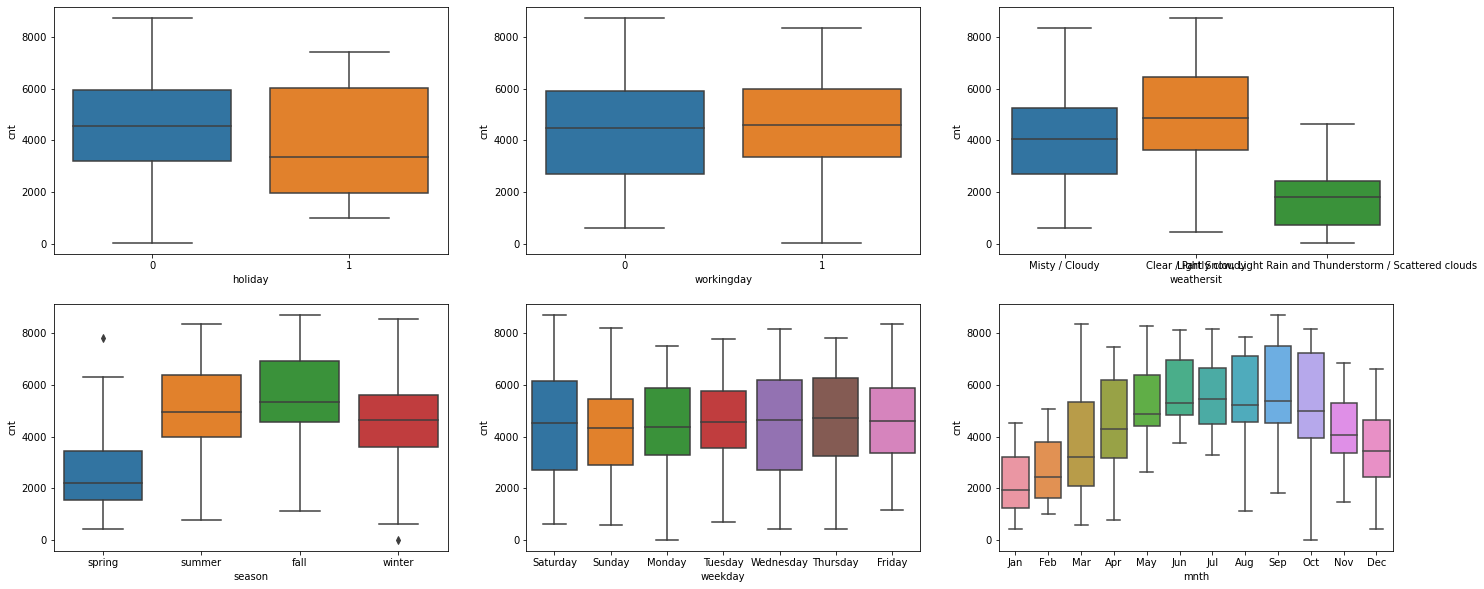

In [850]:
# visualize categorical variable
plt.figure(figsize=(24, 10))

plt.subplot(2,3,1)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike_sharing_df)

plt.subplot(2,3,2)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_sharing_df)

plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_sharing_df)

plt.subplot(2,3,4)
sns.boxplot(x = 'season', y = 'cnt', data = bike_sharing_df)

plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike_sharing_df)

plt.subplot(2,3,6)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike_sharing_df)

plt.show()


### Box plot between categorical variables insights
1) During hollidays the median usage is less than that of a non-holiday.  
2) Weather situation clearly has an influence over the count / total usage. Usage is high during clear days and much less during rainy days.  
3) Summer and fall seasons have higher usage compared to spring or winter.  
4) usage on all weekdays more or less have the same median.  
5) Jan to Jun shows a steady increase in usage and then usage gradually comes down from there to Dec. Could be the holiday seasons impacting the usage

### Working with date field and deriving more data out of it
Extracting day of month and quarter from date field which were not present in the datatset. This will help to capure the impact   of these fields on the target variable. Since the date field itself is redundant post the extraction of these fields, we will remove it

In [851]:
# working with dteday
# Convert this to datetime so it becomes easy to extract day, quarter
bike_sharing_df['dteday'] = pd.to_datetime(bike_sharing_df['dteday'], format='%d-%m-%Y')

In [852]:
# create day of month and create quarter as well so that we can capture quarterly trends as well
bike_sharing_df['dayofmonth'] = bike_sharing_df['dteday'].dt.day

In [853]:
# create quarter
bike_sharing_df['quarter'] = bike_sharing_df['dteday'].dt.quarter

In [854]:
# Since now we have day of month, day of week (weekday), year (0,1) and quarter, let's drop the date.
bike_sharing_df = bike_sharing_df.drop('dteday', axis=1)

### Encode the categorical variables using one hot encoding by creating dummy variables. Below considerations are made.  

1) Considering year as a continuous variable. There is a trend of increase in usage from 2018 to 2019, this will be better captured in prediction when we consider this as a continuous variable. If we encode year as categorical variable when a get a new year in prediction, the coefficient of year will become redundant.  

2) Considering Quarter, Day of the week, Holidays, working days, month etc as categorical variables as they are. This will better capture the impact of these fields on the target variable.  

3) Considering day of the month as a continuous variable. This is a call taken after considering that the model will become too focused if we consider this as a categorical variable and also increase the feature set considerably. 


In [855]:
# get quarter also strings
bike_sharing_df['quarter'] = bike_sharing_df['quarter'].replace({1:'First_Quarter', 2:'Second_quarter', 3:'Third_Quarter', 4:'4th Quarter'})

In [856]:
# holiday and working day is already a binary with a zero and one, so no need to encode them
season = pd.get_dummies(bike_sharing_df['season'], drop_first=True)

# concatenate the season dummy vars to the original dataset
bike_sharing_df = pd.concat([bike_sharing_df, season], axis=1)

# drop season after concat
bike_sharing_df = bike_sharing_df.drop('season', axis=1)

bike_sharing_df.head()

,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,dayofmonth,quarter,spring,summer,winter
0,0,Jan,0,Saturday,0,Misty / Cloudy,18.18125,80.5833,10.749882,985,1,First_Quarter,1,0,0
1,0,Jan,0,Sunday,0,Misty / Cloudy,17.68695,69.6087,16.652113,801,2,First_Quarter,1,0,0
2,0,Jan,0,Monday,1,Clear / Partly cloudy,9.47025,43.7273,16.636703,1349,3,First_Quarter,1,0,0
3,0,Jan,0,Tuesday,1,Clear / Partly cloudy,10.60610,59.0435,10.739832,1562,4,First_Quarter,1,0,0
4,0,Jan,0,Wednesday,1,Clear / Partly cloudy,11.46350,43.6957,12.522300,1600,5,First_Quarter,1,0,0


In [857]:
# Encode weekday and drop weekday after concatenating the dummies with the main dataset. Also for better interpretability substituting the actual weekdays first
weekday = pd.get_dummies(bike_sharing_df['weekday'], drop_first=True)

# concatenate the season dummy vars to the original dataset
bike_sharing_df = pd.concat([bike_sharing_df, weekday], axis=1)

# drop season after concat
bike_sharing_df = bike_sharing_df.drop('weekday', axis=1)

bike_sharing_df.head()

,yr,mnth,holiday,workingday,weathersit,atemp,hum,windspeed,cnt,dayofmonth,quarter,spring,summer,winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,Jan,0,0,Misty / Cloudy,18.18125,80.5833,10.749882,985,1,First_Quarter,1,0,0,0,1,0,0,0,0
1,0,Jan,0,0,Misty / Cloudy,17.68695,69.6087,16.652113,801,2,First_Quarter,1,0,0,0,0,1,0,0,0
2,0,Jan,0,1,Clear / Partly cloudy,9.47025,43.7273,16.636703,1349,3,First_Quarter,1,0,0,1,0,0,0,0,0
3,0,Jan,0,1,Clear / Partly cloudy,10.60610,59.0435,10.739832,1562,4,First_Quarter,1,0,0,0,0,0,0,1,0
4,0,Jan,0,1,Clear / Partly cloudy,11.46350,43.6957,12.522300,1600,5,First_Quarter,1,0,0,0,0,0,0,0,1


In [858]:
# Encode and drop weathersit after concatenating the dummies with the main dataset. Also for better interpretability substituting the actual weathersit first
weathersit = pd.get_dummies(bike_sharing_df['weathersit'], drop_first=True)

# concatenate the season dummy vars to the original dataset
bike_sharing_df = pd.concat([bike_sharing_df, weathersit], axis=1)

# drop season after concat
bike_sharing_df = bike_sharing_df.drop('weathersit', axis=1)

bike_sharing_df.head()

,yr,mnth,holiday,workingday,atemp,hum,windspeed,cnt,dayofmonth,quarter,...,summer,winter,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,"Light Snow, Light Rain and Thunderstorm / Scattered clouds",Misty / Cloudy
0,0,Jan,0,0,18.18125,80.5833,10.749882,985,1,First_Quarter,...,0,0,0,1,0,0,0,0,0,1
1,0,Jan,0,0,17.68695,69.6087,16.652113,801,2,First_Quarter,...,0,0,0,0,1,0,0,0,0,1
2,0,Jan,0,1,9.47025,43.7273,16.636703,1349,3,First_Quarter,...,0,0,1,0,0,0,0,0,0,0
3,0,Jan,0,1,10.60610,59.0435,10.739832,1562,4,First_Quarter,...,0,0,0,0,0,0,1,0,0,0
4,0,Jan,0,1,11.46350,43.6957,12.522300,1600,5,First_Quarter,...,0,0,0,0,0,0,0,1,0,0


In [859]:
# Encode and drop quarter after concatenating the dummies with the main dataset. Also for better interpretability substituting the actual quarter first
quarter = pd.get_dummies(bike_sharing_df['quarter'], drop_first=True)

# concatenate the season dummy vars to the original dataset
bike_sharing_df = pd.concat([bike_sharing_df, quarter], axis=1)

# drop season after concat
bike_sharing_df = bike_sharing_df.drop('quarter', axis=1)

bike_sharing_df.head()

,yr,mnth,holiday,workingday,atemp,hum,windspeed,cnt,dayofmonth,spring,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,"Light Snow, Light Rain and Thunderstorm / Scattered clouds",Misty / Cloudy,First_Quarter,Second_quarter,Third_Quarter
0,0,Jan,0,0,18.18125,80.5833,10.749882,985,1,1,...,1,0,0,0,0,0,1,1,0,0
1,0,Jan,0,0,17.68695,69.6087,16.652113,801,2,1,...,0,1,0,0,0,0,1,1,0,0
2,0,Jan,0,1,9.47025,43.7273,16.636703,1349,3,1,...,0,0,0,0,0,0,0,1,0,0
3,0,Jan,0,1,10.60610,59.0435,10.739832,1562,4,1,...,0,0,0,1,0,0,0,1,0,0
4,0,Jan,0,1,11.46350,43.6957,12.522300,1600,5,1,...,0,0,0,0,1,0,0,1,0,0


In [860]:
# Encode and drop month after concatenating the dummies with the main dataset. Also for better interpretability substituting the actual quarter first
month = pd.get_dummies(bike_sharing_df['mnth'], drop_first=True)

# concatenate the season dummy vars to the original dataset
bike_sharing_df = pd.concat([bike_sharing_df, month], axis=1)

# drop season after concat
bike_sharing_df = bike_sharing_df.drop('mnth', axis=1)

bike_sharing_df.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,dayofmonth,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,18.18125,80.5833,10.749882,985,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,17.68695,69.6087,16.652113,801,2,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,9.47025,43.7273,16.636703,1349,3,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,10.60610,59.0435,10.739832,1562,4,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,11.46350,43.6957,12.522300,1600,5,1,0,...,0,0,1,0,0,0,0,0,0,0


### Now that all the categorical variables are encoded - Let's split the data into train and test sets and do scaling of variables

In [861]:
#Split into train and test and do some rescaling of variables
df_train, df_test = train_test_split(bike_sharing_df, train_size = 0.70, random_state = 100)
df_train.shape

(510, 33)

In [862]:
# rescale numeric varaibles

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# list of numeric varables
num_vars = ['yr', 'dayofmonth', 'atemp', 'hum', 'windspeed', 'cnt']

# fit_transform the scaler
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [863]:
# make sure all values are as expected by getting a peek at the df
df_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,dayofmonth,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
576,1.0,0,1,0.766351,0.659744,0.264686,0.827658,1.000000,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1.0,0,0,0.438975,0.553780,0.255342,0.465255,0.066667,1,0,...,0,0,0,0,0,1,0,0,0,0
728,1.0,0,0,0.200348,0.377528,0.663106,0.204096,0.966667,1,0,...,1,0,0,0,0,0,0,0,0,0
482,1.0,0,0,0.391735,0.385516,0.188475,0.482973,0.900000,0,1,...,0,0,0,0,0,0,0,0,0,0
111,0.0,0,1,0.318819,0.692225,0.380981,0.191095,0.700000,0,1,...,0,0,0,0,0,0,0,0,0,0


In [864]:
# rearranging columns so it will be easier to look at correlation metrics
col_to_move = 'cnt'
cols = [col_to_move] + [col for col in df_train.columns if col != col_to_move]
df_train = df_train[cols]

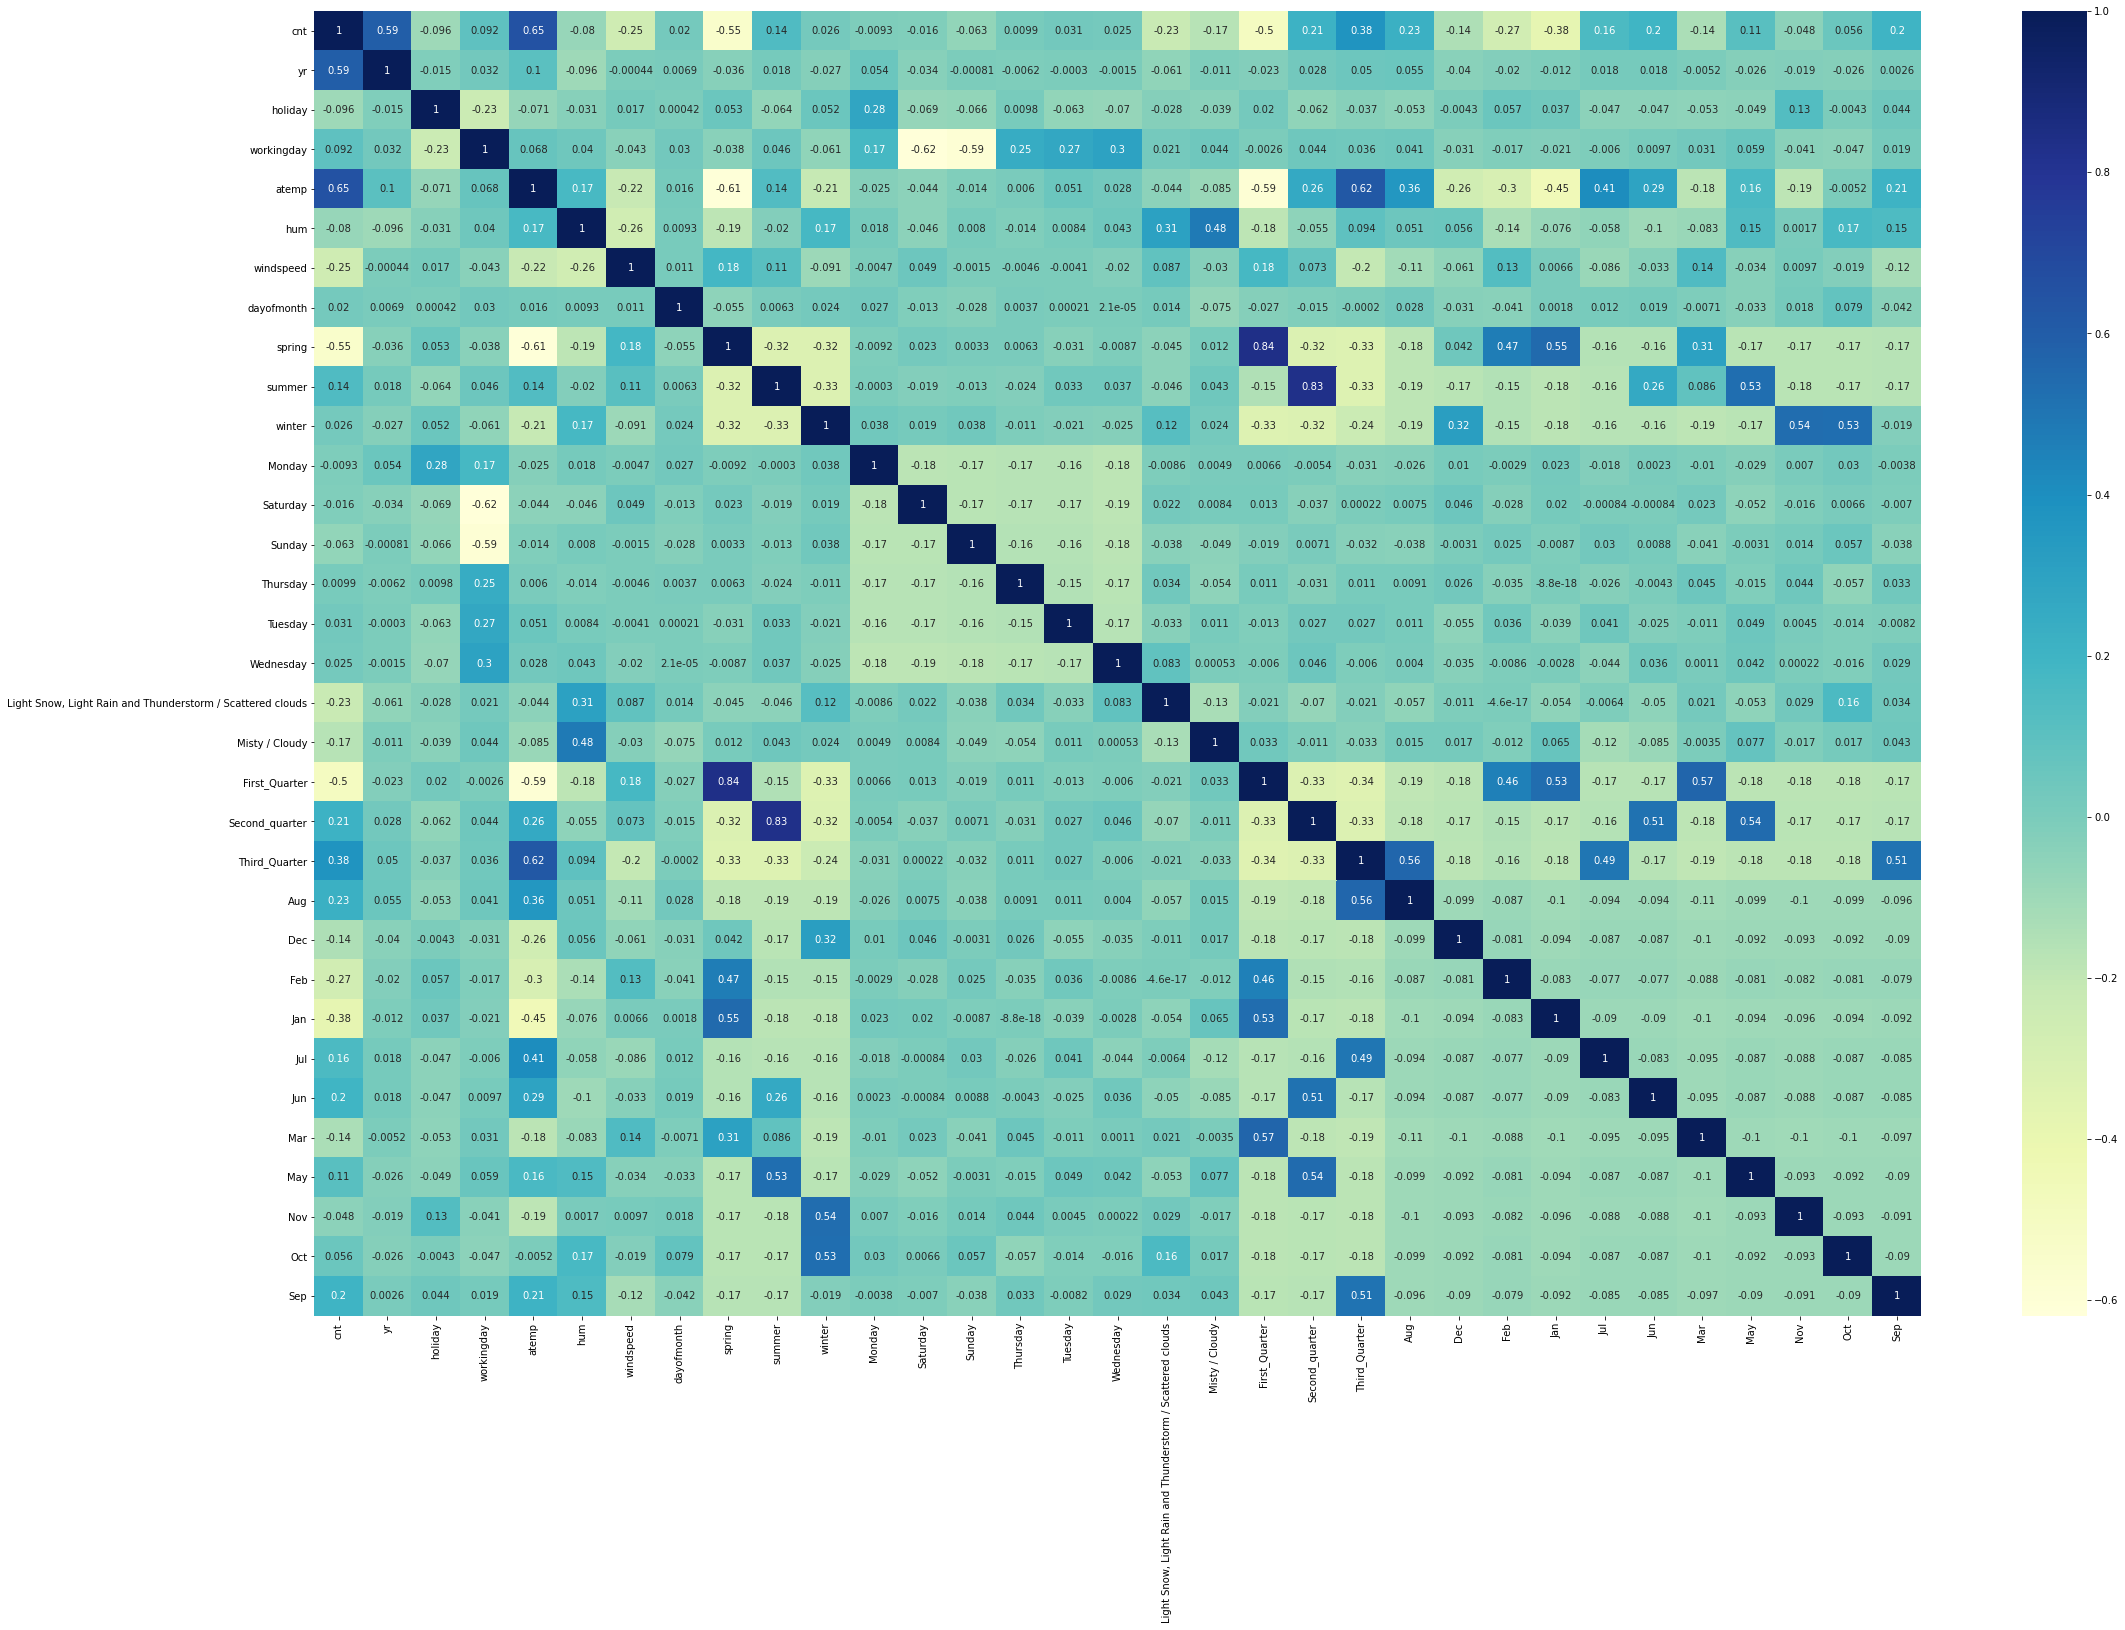

In [865]:
# plot a correlation metric
plt.figure(figsize=(36,24))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

### There are few variables with really high correlation with cnt, like temperature and year. 

In [866]:
# create X and y (target)
y_train = df_train.pop('cnt')
X_train = df_train

In [867]:
# We will construct a model with all the variables first, look at statistics and then decide to reduce the features

# add constant for the intercept first
X_train_sm = sm.add_constant(X_train)

In [868]:
# create lr object using OLS
lr = sm.OLS(y_train, X_train_sm)

In [869]:
# fit the model
lr_model = lr.fit()

In [870]:
# summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     97.71
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          8.46e-179
Time:                        23:50:57   Log-Likelihood:                 523.48
No. Observations:                 510   AIC:                            -989.0
Df Residuals:                     481   BIC:                            -866.2
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.1982      0.025      7.895      0.000       0.149       0.247
yr                                                             0.2338      0.008     28.768      0.000       0.218       0.250
holiday                                                        0.0060      0.023      0.261      0.794      -0.039       0.051
workingday                                                     0.0851      0.011      7.724      0.000       0.063       0.107
atemp                                                          0.4207      0.046      9.198      0.000       0.331       0.511
hum                                                           -0.1274      0.034     -3.787      0.000      -0.193      -0.061
windspeed                                                     -0.1704      0.026     -6.527      0.000      -0.222      -0.119
dayofmonth                                                    -0.0038      0.014     -0.277      0.782      -0.030       0.023
spring                                                        -0.0494      0.030     -1.633      0.103      -0.109       0.010
summer                                                         0.0350      0.026      1.333      0.183      -0.017       0.087
winter                                                         0.1030      0.028      3.651      0.000       0.048       0.158
Monday                                                        -0.0261      0.015     -1.689      0.092      -0.056       0.004
Saturday                                                       0.0804      0.013      6.376      0.000       0.056       0.105
Sunday                                                         0.0267      0.013      2.077      0.038       0.001       0.052
Thursday                                                      -0.0118      0.016     -0.752      0.452      -0.043       0.019
Tuesday                                                       -0.0213      0.016     -1.362      0.174      -0.052       0.009
Wednesday                                                     -0.0085      0.015     -0.568      0.570      -0.038       0.021
Light Snow, Light Rain and Thunderstorm / Scattered clouds    -0.2417      0.028     -8.639      0.000      -0.297      -0.187
Misty / Cloudy                                                -0.0593      0.011     -5.477      0.000      -0.081      -0.038
First_Quarter                                                  0.0104      0.014      0.731      0.465      -0.018       0.039
Second_quarter                                                 0.0526      0.024      2.206      0.028       0.006       0.099
Third_Quarter                      

### The model has good Rsquare however will try eliminating features using RFE from sklearn

In [871]:
# select best 15 features
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 15)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [872]:
# Get the columns and their rank
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 3),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('dayofmonth', False, 18),
 ('spring', True, 1),
 ('summer', False, 6),
 ('winter', True, 1),
 ('Monday', False, 13),
 ('Saturday', False, 2),
 ('Sunday', False, 12),
 ('Thursday', False, 16),
 ('Tuesday', False, 15),
 ('Wednesday', False, 17),
 ('Light Snow, Light Rain and Thunderstorm / Scattered clouds', True, 1),
 ('Misty / Cloudy', True, 1),
 ('First_Quarter', True, 1),
 ('Second_quarter', False, 10),
 ('Third_Quarter', False, 7),
 ('Aug', False, 11),
 ('Dec', True, 1),
 ('Feb', False, 14),
 ('Jan', False, 5),
 ('Jul', True, 1),
 ('Jun', False, 8),
 ('Mar', True, 1),
 ('May', False, 4),
 ('Nov', True, 1),
 ('Oct', False, 9),
 ('Sep', True, 1)]

In [873]:
# columns selected by RFE
cols = X_train.columns[rfe.support_]

In [874]:
# create training data with RFE selected columns
X_train_rfe = X_train[cols]

In [875]:
# create a model using statsmodels so we can get the summary
X_train_sm = sm.add_constant(X_train_rfe)

In [876]:
# create model
lm = sm.OLS(y_train, X_train_sm).fit()

In [877]:
# summary of the model built using features selected by RFE
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     174.5
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          2.72e-186
Time:                        23:51:15   Log-Likelihood:                 508.16
No. Observations:                 510   AIC:                            -984.3
Df Residuals:                     494   BIC:                            -916.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.3543      0.030     11.666      0.000       0.295       0.414
yr                                                             0.2317      0.008     28.286      0.000       0.216       0.248
holiday                                                       -0.0837      0.026     -3.223      0.001      -0.135      -0.033
atemp                                                          0.4389      0.038     11.552      0.000       0.364       0.514
hum                                                           -0.1348      0.033     -4.111      0.000      -0.199      -0.070
windspeed                                                     -0.1695      0.026     -6.492      0.000      -0.221      -0.118
spring                                                        -0.0843      0.021     -3.996      0.000      -0.126      -0.043
winter                                                         0.0666      0.014      4.689      0.000       0.039       0.094
Light Snow, Light Rain and Thunderstorm / Scattered clouds    -0.2351      0.028     -8.424      0.000      -0.290      -0.180
Misty / Cloudy                                                -0.0540      0.011     -4.989      0.000      -0.075      -0.033
First_Quarter                                                 -0.0669      0.027     -2.495      0.013      -0.120      -0.014
Dec                                                           -0.0579      0.020     -2.858      0.004      -0.098      -0.018
Jul                                                           -0.0674      0.017     -3.888      0.000      -0.101      -0.033
Mar                                                            0.0611      0.019      3.224      0.001       0.024       0.098
Nov                                                           -0.0543      0.019     -2.801      0.005      -0.092      -0.016
Sep                                                            0.0581      0.016      3.703      0.000       0.027       0.089
==============================================================================
Omnibus:                       74.577   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.817
Skew:                          -0.720   Prob(JB):                     1.50e-44
Kurtosis:                       5.724   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [878]:
# Compute VIF
VIF_data = pd.DataFrame()
features = X_train_rfe
VIF_data['feature'] = features.columns
VIF_data['VIF'] = [variance_inflation_factor(features.values, i) 
                          for i in range(len(features.columns))] 

VIF_data

,feature,VIF
0,yr,2.087252
1,holiday,1.063446
2,atemp,14.641096
3,hum,19.494653
4,windspeed,4.066294
5,spring,6.663362
6,winter,2.890431
7,"Light Snow, Light Rain and Thunderstorm / Scat...",1.386281
8,Misty / Cloudy,2.469967
9,First_Quarter,9.295243


In [879]:
# remove humidity which has a very high ViF
X_train_new = X_train_rfe.drop('hum', axis=1)

In [880]:
# create a new model
X_train_sm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train, X_train_sm).fit()

In [881]:
# summary of the model built using features selected by RFE
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     180.0
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          7.74e-184
Time:                        23:51:26   Log-Likelihood:                 499.58
No. Observations:                 510   AIC:                            -969.2
Df Residuals:                     495   BIC:                            -905.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.3022      0.028     10.777      0.000       0.247       0.357
yr                                                             0.2361      0.008     28.606      0.000       0.220       0.252
holiday                                                       -0.0848      0.026     -3.215      0.001      -0.137      -0.033
atemp                                                          0.3980      0.037     10.683      0.000       0.325       0.471
windspeed                                                     -0.1402      0.026     -5.493      0.000      -0.190      -0.090
spring                                                        -0.0883      0.021     -4.124      0.000      -0.130      -0.046
winter                                                         0.0570      0.014      4.008      0.000       0.029       0.085
Light Snow, Light Rain and Thunderstorm / Scattered clouds    -0.2900      0.025    -11.647      0.000      -0.339      -0.241
Misty / Cloudy                                                -0.0808      0.009     -9.195      0.000      -0.098      -0.064
First_Quarter                                                 -0.0706      0.027     -2.595      0.010      -0.124      -0.017
Dec                                                           -0.0645      0.021     -3.145      0.002      -0.105      -0.024
Jul                                                           -0.0585      0.017     -3.351      0.001      -0.093      -0.024
Mar                                                            0.0627      0.019      3.258      0.001       0.025       0.101
Nov                                                           -0.0543      0.020     -2.753      0.006      -0.093      -0.016
Sep                                                            0.0547      0.016      3.433      0.001       0.023       0.086
==============================================================================
Omnibus:                       77.138   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.901
Skew:                          -0.744   Prob(JB):                     4.34e-46
Kurtosis:                       5.760   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [882]:
# Compute VIF
VIF_data = pd.DataFrame()
features = X_train_new
VIF_data['feature'] = features.columns
VIF_data['VIF'] = [variance_inflation_factor(features.values, i) 
                          for i in range(len(features.columns))] 

VIF_data

,feature,VIF
0,yr,2.068335
1,holiday,1.063296
2,atemp,4.622410
3,windspeed,4.044174
4,spring,6.617881
5,winter,2.623522
6,"Light Snow, Light Rain and Thunderstorm / Scat...",1.088761
7,Misty / Cloudy,1.544361
8,First_Quarter,8.707931
9,Dec,1.759316


In [883]:
# remove first quarter as well
X_train_new = X_train_new.drop('First_Quarter', axis=1)

In [884]:
# create a new model
X_train_sm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train, X_train_sm).fit()

In [885]:
# summary of the model built using features selected by RFE
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     191.1
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          1.53e-183
Time:                        23:51:36   Log-Likelihood:                 496.13
No. Observations:                 510   AIC:                            -964.3
Df Residuals:                     496   BIC:                            -905.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.2677      0.025     10.780      0.000       0.219       0.317
yr                                                             0.2350      0.008     28.347      0.000       0.219       0.251
holiday                                                       -0.0858      0.027     -3.235      0.001      -0.138      -0.034
atemp                                                          0.4438      0.033     13.450      0.000       0.379       0.509
windspeed                                                     -0.1316      0.025     -5.171      0.000      -0.182      -0.082
spring                                                        -0.1273      0.015     -8.298      0.000      -0.157      -0.097
winter                                                         0.0578      0.014      4.039      0.000       0.030       0.086
Light Snow, Light Rain and Thunderstorm / Scattered clouds    -0.2885      0.025    -11.524      0.000      -0.338      -0.239
Misty / Cloudy                                                -0.0812      0.009     -9.194      0.000      -0.099      -0.064
Dec                                                           -0.0357      0.017     -2.058      0.040      -0.070      -0.002
Jul                                                           -0.0630      0.017     -3.603      0.000      -0.097      -0.029
Mar                                                            0.0306      0.015      2.062      0.040       0.001       0.060
Nov                                                           -0.0403      0.019     -2.112      0.035      -0.078      -0.003
Sep                                                            0.0573      0.016      3.584      0.000       0.026       0.089
==============================================================================
Omnibus:                       68.988   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.408
Skew:                          -0.689   Prob(JB):                     1.34e-38
Kurtosis:                       5.511   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [886]:
# Compute VIF
VIF_data = pd.DataFrame()
features = X_train_new
VIF_data['feature'] = features.columns
VIF_data['VIF'] = [variance_inflation_factor(features.values, i) 
                          for i in range(len(features.columns))] 

VIF_data

,feature,VIF
0,yr,2.052354
1,holiday,1.062868
2,atemp,4.556087
3,windspeed,3.990500
4,spring,1.797412
5,winter,2.539649
6,"Light Snow, Light Rain and Thunderstorm / Scat...",1.088682
7,Misty / Cloudy,1.521096
8,Dec,1.434800
9,Jul,1.354355


### The latest model has 12 features with none of them having a ViF of more than 5 and a p value higher than 0.05. Let's check the error terms to see their distribution

In [887]:
# predict y for the training data
y_train_pred = lm.predict(X_train_sm)

In [888]:
# calculate residual
res = y_train - y_train_pred

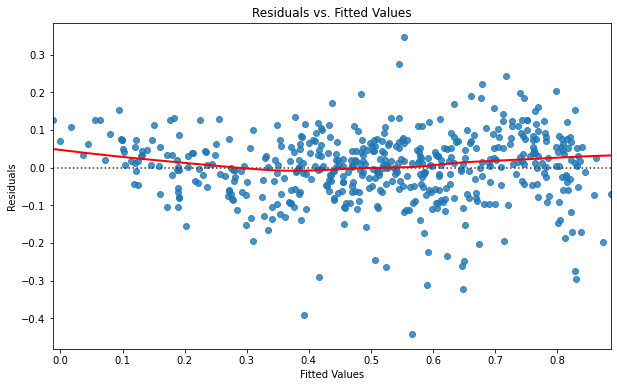

In [889]:
# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
sns.residplot(x=y_train_pred, y=res, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

### No pattern between residuals and fitted values and the residuals  are scattered around horizontal axis

In [890]:
durbin_watson = sm.stats.stattools.durbin_watson(res)
print(f'Durbin-Watson statistic: {durbin_watson}')

Durbin-Watson statistic: 2.0049772668207226


###  Durbin-Watson statistic of 2.00 means there is no auto correlation in the residuals

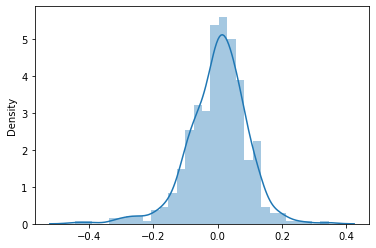

In [893]:
# plot distribution
sns.distplot(res)
plt.show()

### Error terms follow a normal distribution centered to Zero. Now evaluate the model on training data

In [894]:
# list of numeric varables
num_vars = ['yr', 'dayofmonth', 'atemp', 'hum', 'windspeed', 'cnt']

# transform the scaler
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [895]:
df_test.describe()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,dayofmonth,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.532847,0.551340,0.313293,0.522154,0.500606,0.254545,0.263636,...,0.086364,0.100000,0.077273,0.104545,0.095455,0.054545,0.086364,0.072727,0.086364,0.086364
std,0.500809,0.187620,0.459303,0.217401,0.184403,0.159584,0.219163,0.285182,0.436599,0.441609,...,0.281541,0.300684,0.267633,0.306665,0.294512,0.227609,0.281541,0.260281,0.281541,0.281541
min,0.000000,0.000000,0.000000,0.025950,0.084665,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.344870,0.416134,0.198843,0.378595,0.258333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.544652,0.535676,0.300126,0.524678,0.483333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.713308,0.682271,0.402718,0.677750,0.766667,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.980934,1.002662,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [896]:
# create X and y
y_test = df_test.pop('cnt')
X_test = df_test

In [897]:
# Keep only the columns as in the latest train set used for the latest model
columns_in_latest_train = X_train_new.columns

# keep only these columns in test set
X_test = X_test[columns_in_latest_train]

In [898]:
# add constant
X_test_sm = sm.add_constant(X_test)

In [899]:
# predict test set
y_test_pred = lm.predict(X_test_sm)

In [900]:
# evaluate model by using r2score
r2_score(y_true=y_test, y_pred=y_test_pred)

0.8224980636611101

### The model has a R-Square of 0.82 on the test set which is similar to the 0.83 on the train set. This poves that model generalises well on unseen data as well

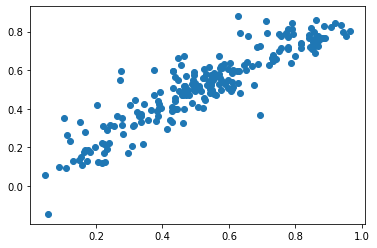

In [901]:
# plot predicted vs actual
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
plt.show()

### The scatter plot of predicted and actual values of cnt on the test set also follows a linear pattern as expected

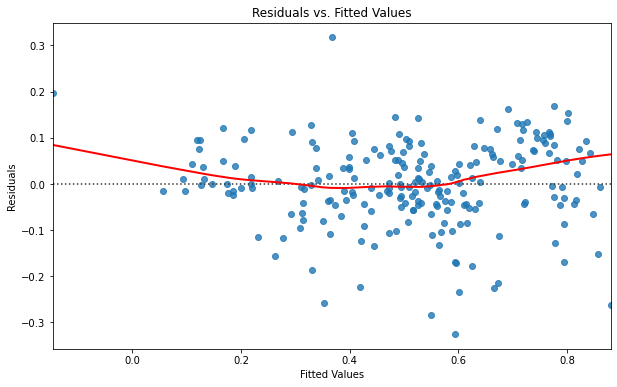

In [902]:
# Plot residuals vs fitted values
res = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test_pred, y=res, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

### Residuals vs Fit values shows no pattern as expected 